In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K

In [2]:
def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [3]:
def dice_coeff(y_true, y_pred, smoothness = 100):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smoothness) / (K.sum(y_true_f) + K.sum(y_pred_f) + smoothness)

In [4]:
def precision(y_true, y_pred):    
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

In [5]:
def recall(y_true, y_pred):    
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

In [6]:
def accuracy(y_true, y_pred):    
  return K.mean(K.equal(y_true, K.round(y_pred)))

In [7]:
def double_conv(x, num_filters):
  x = Conv2D(num_filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  return x

In [8]:
def gating_signal(input, output_size):
  x = Conv2D(output_size, (1, 1), padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [9]:
def expend_as(tensor, rep):
  return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                      arguments={'repnum': rep})(tensor)

In [10]:
def attention_block(x, gating, inter_shape):
  shape_x = K.int_shape(x)
  shape_g = K.int_shape(gating)

  theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
  shape_theta_x = K.int_shape(theta_x)

  phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
  upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                padding='same')(phi_g)

  concat_xg = add([upsample_g, theta_x])
  act_xg = Activation('relu')(concat_xg)
  psi = Conv2D(1, (1, 1), padding='same')(act_xg)
  sigmoid_xg = Activation('sigmoid')(psi)
  shape_sigmoid = K.int_shape(sigmoid_xg)
  upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

  upsample_psi = expend_as(upsample_psi, shape_x[3])

  y = multiply([upsample_psi, x])

  result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
  result_bn = BatchNormalization()(result)
  return result_bn

In [11]:
def UNET_Channel_Attention():
    
  input_shape = 256
  num_filters = 64
  input_layer = Input(shape=(input_shape, input_shape, 3))  
  
  #Downsampling
  conv_128 = double_conv(input_layer, num_filters)
  pool_64 = MaxPooling2D()(conv_128)

  conv_64 = double_conv(pool_64, num_filters*2)
  pool_32 = MaxPooling2D()(conv_64)

  conv_32 = double_conv(pool_32, num_filters*4)
  pool_16 = MaxPooling2D()(conv_32)

  conv_16 = double_conv(pool_16, num_filters*8)
  pool_8 = MaxPooling2D()(conv_16)

  conv_8 = double_conv(pool_8, num_filters*16)

  #Upsampling
  gating_16 = gating_signal(conv_8, num_filters*8)
  att_16 = attention_block(conv_16, gating_16, num_filters*8)
  up_16 = UpSampling2D(data_format="channels_last")(conv_8)
  up_16 = concatenate([up_16, att_16], axis = 3)
  up_conv_16 = double_conv(up_16, num_filters*8)

  gating_32 = gating_signal(up_conv_16, num_filters*4)
  att_32 = attention_block(conv_32, gating_32, num_filters*4)
  up_32 = UpSampling2D(data_format="channels_last")(up_conv_16)
  up_32 = concatenate([up_32, att_32], axis = 3)
  up_conv_32 = double_conv(up_32, num_filters*4)

  gating_64 = gating_signal(up_conv_32, num_filters*2)
  att_64 = attention_block(conv_64, gating_64, num_filters*2)
  up_64 = UpSampling2D(data_format="channels_last")(up_conv_32)
  up_64 = concatenate([up_64, att_64], axis = 3)
  up_conv_64 = double_conv(up_64, num_filters*2)

  gating_128 = gating_signal(up_conv_64, num_filters)
  att_128 = attention_block(conv_128, gating_128, num_filters)
  up_128 = UpSampling2D(data_format="channels_last")(up_conv_64)
  up_128 = concatenate([up_128, att_128], axis = 3)
  up_conv_128 = double_conv(up_128, num_filters)

  conv_final = Conv2D(1, (1, 1))(up_conv_128)
  conv_final = BatchNormalization(axis = 3)(conv_final)
  conv_final = Activation("relu")(conv_final)

  return Model(input_layer, conv_final, name="UNET_Channel")

In [12]:
lr = 1e-4
model = UNET_Channel_Attention()
model.compile(optimizer=Adam(learning_rate=lr), loss=['binary_crossentropy'],
              metrics=[iou, dice_coeff, precision, recall, accuracy])
model.summary()

Model: "UNET_Channel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

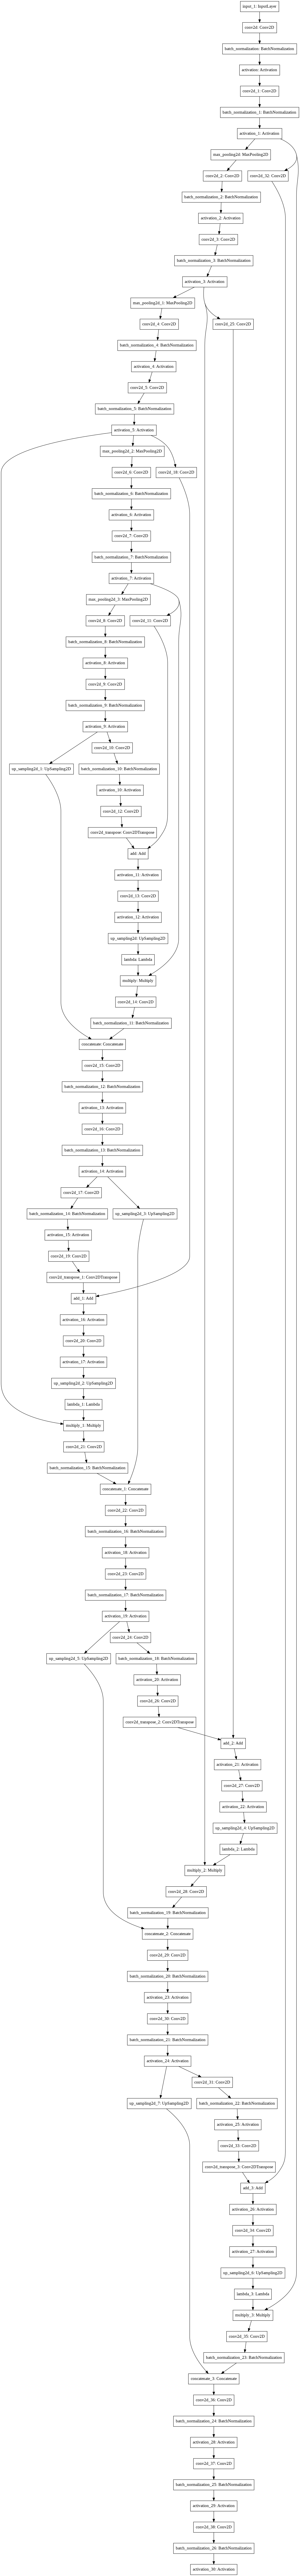

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import backend as K
import os
from sklearn.model_selection import train_test_split

In [15]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
  parts = numbers.split(value)
  parts[1::2] = map(int, parts[1::2])
  return parts

In [16]:
def load_data(split=0.1):  
  images= sorted(glob.glob('/content/drive/MyDrive/ph2/*/trainx/*.bmp'), key=numericalSort)
  masks = sorted(glob.glob('/content/drive/MyDrive/ph2/*/trainy/*.bmp'), key=numericalSort)

  total_size = len(images)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)

  train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=101)
  train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=101)

  train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=101)
  train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=101)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [17]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  return x

In [18]:
def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  x = np.expand_dims(x, axis=-1)
  return x

In [19]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y
    
  x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 1])
  return x, y

In [20]:
def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

In [21]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

In [22]:
batch = 8
epochs = 50
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [23]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

In [24]:
history = model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps)

Epoch 1/50
20/20 [==============================] - 329s 14s/step - loss: 1.5360 - iou: 0.7628 - dice_coeff: 0.8487 - precision: 0.7517 - recall: 0.6447 - accuracy: 0.7300 - val_loss: 3.7833 - val_iou: 1.0795e-20 - val_dice_coeff: 0.0011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 2/50
20/20 [==============================] - 32s 2s/step - loss: 0.7950 - iou: 0.7725 - dice_coeff: 0.8685 - precision: 0.7845 - recall: 0.7390 - accuracy: 0.7749 - val_loss: 3.7833 - val_iou: 1.8699e-08 - val_dice_coeff: 0.0011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 3/50
20/20 [==============================] - 31s 2s/step - loss: 0.5912 - iou: 0.7050 - dice_coeff: 0.8240 - precision: 0.8077 - recall: 0.7506 - accuracy: 0.8049 - val_loss: 3.7832 - val_iou: 1.5244e-06 - val_dice_coeff: 0.0011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 4/50
20/20 [==============================] - 32s 2s/ste

In [25]:
def mask_parse(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask

In [26]:
def read_image(path):
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  return x

def read_mask(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = np.expand_dims(x, axis=-1)
  return x

In [27]:
def display_new(no=0):
  x=test_x[no]
  y=test_y[no]
  plt.figure(figsize=(15, 15))
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  x_r = read_image(x)
  plt.imshow(x_r)
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title('Ground Truth')
  y_r = read_image(y)
  plt.imshow(y_r)
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.title('Predicted Image')
  x=read_image(x)
  y=read_mask(y)
  y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
  y_pred = mask_parse(y_pred) * 255.0
  y_pred = cv2.resize(y_pred, (256, 256))
  plt.imshow(y_pred, cmap='gray')
  plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


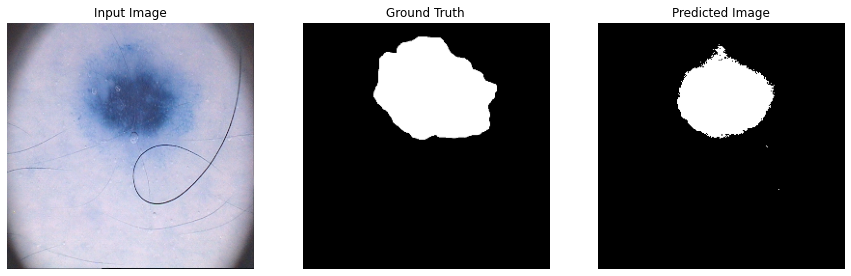

In [28]:
display_new(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


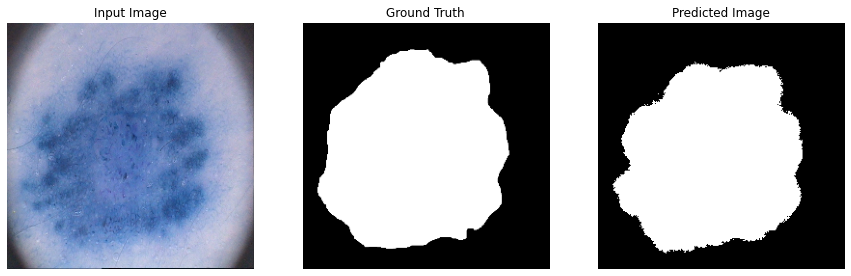

In [29]:
display_new(5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


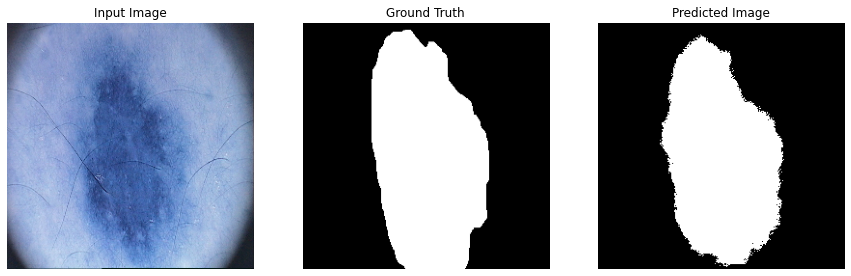

In [30]:
display_new(17)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


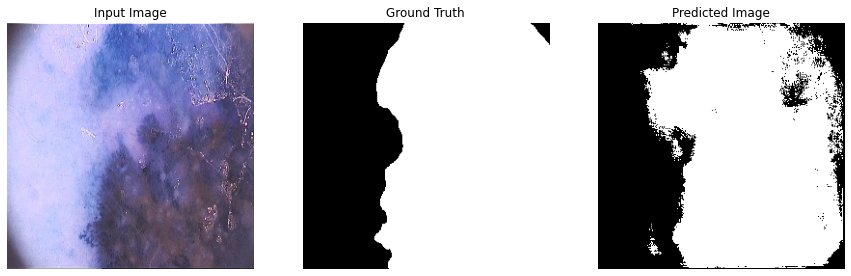

In [31]:
display_new(19)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


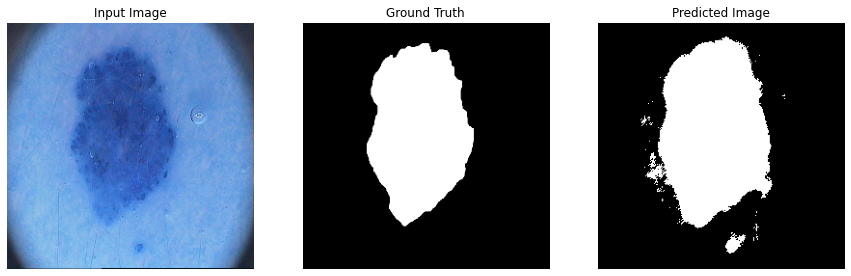

In [32]:
display_new(7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


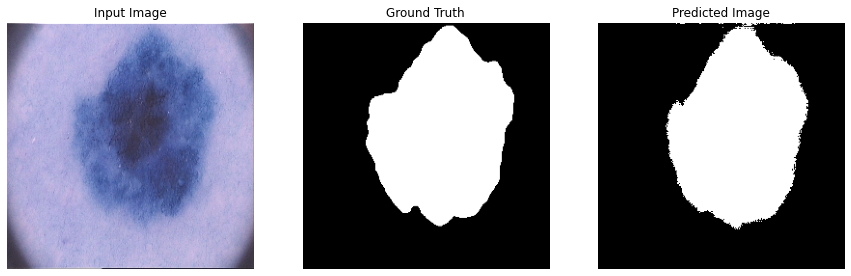

In [33]:
display_new(0)